In [1]:
from distutils.command import config

def random_search(problem, function_evaluations=10, **kwargs):

    history = []
    configs = []

    RANGES = GET_RANGES(problem) 

    for j in range(function_evaluations):
        config={}
        
        for i in RANGES:
            # If there is a condition, check if it holds.
            # If not, skip this hyperparameter
            if(condition(RANGES, config, i)):
                continue
            
            a = RANGES[i]['range'][0] 
            b = RANGES[i]['range'][1] 
            
            # If uniform
            if(RANGES[i]['sample']==0):
                if (RANGES[i]["type"] == 0):
                    value=np.random.choice(RANGES[i]['range']) 
                    config[i]=value  
                elif (RANGES[i]["type"] == 1):
                    value=np.random.uniform(a, b) 
                    config[i]=value
                else:
                    value=np.random.randint(a, b+1) 
                    config[i]=value
            # Else log        
            else:
                value=np.random.uniform(np.log(a), np.log(b)) 
                config[i]=np.exp(value) # exponentiate value back 
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config))

    return history, configs

# Function for checking if hyperparameter has a condition and whether it holds
def condition(ranges, config, i):
        if('condition' in ranges[i]):
            if (ranges[i]['condition'](config) == False):
                return True

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\2410849161.py:1: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  from distutils.command import config


In [105]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm

def tpe(problem, function_evaluations=150, random_warmup=30, gamma=0.2, n=3, **kwargs):

    RANGES = GET_RANGES(problem) 
    
    # Initial warm-up using random search
    for i in range(random_warmup):
        loss,configs=random_search(problem,function_evaluations)    

    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss
    
    for i in range(5):
        sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
        good_df, bad_df = good_bad(gamma, sorted_loss_df)

        samples,probability=(sample(RANGES,good_df,bad_df,n))
        loss.append(GET_CONFIG_PERFORMANCE(samples))
        configs.append(samples)
        hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)
    
    #plotting the first question
    for i in good_df.columns.difference(['loss']):
            plt.xlabel(i)
            plt.scatter(x=good_df[i],y=good_df["loss"],color="red")
            plt.scatter(x=bad_df[i],y=bad_df["loss"],color="blue")
            plt.show()
            
    
    
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, df):
    
    index_value=int(gamma*(df.shape[0]))
    good_dataframe = df.iloc[:index_value]
    bad_dataframe = df.iloc[index_value:df.shape[0]]
    
    #remove all nan values
    good_df=(good_dataframe["configs"].apply(pd.Series))
    bad_df=(bad_dataframe["configs"].apply(pd.Series))

    good_df["loss"]=good_dataframe["loss"]
    bad_df["loss"]=bad_dataframe["loss"]
        
    return good_df, bad_df

# Function that constructs l(x) and samples from it
def sample(RANGES, good_df,bad_df, n):
    
    # List for testing samples
    samples = []
    config={}
    probabilities =[]
    fig, ax = plt.subplots()
    for i in good_df.columns.difference(['loss']):  
        #print(i)
        x = good_df[i].dropna()
        y = bad_df[i].dropna()
        
        # If categorical, sample uniform
        if RANGES[i]['type'] == 0:
            sample = np.random.choice(RANGES[i]['range'])
            samples.append(sample)
            config[i]=sample
            probabilities.append(0)

        else:
            # If sample type = LogUniform
            if (RANGES[i]['sample'] == 1):
                x = np.log(x)
                y = np.log(y)
                
            mean, sd = np.mean(x), np.std(x)
            mean_b, sd_b = np.mean(y), np.std(y)
            
            l_x = normal_dist(x, mean, sd)  
            g_x = normal_dist(y, mean_b, sd_b )

            plt.xlabel(i)
            l_x.plot(kind='density',color="red",xlabel=i)
            g_x.plot(kind='density',color="blue",xlabel=i)
            plt.show()
                
            # Bounds indicate the truncated gaussians
            a,b = -np.inf, np.inf
            
            # Set prob of values x < a or x > b to '0'
            l_x[x < a], l_x[x > b] = 0, 0
            g_x[y < a], g_x[y > b] = 0, 0

            y_cum = np.cumsum(l_x) / l_x.sum()
            
            # n indicates candidate samples
            yrand = np.random.rand(n)
            #takes max of yrand that is max of n samples for each hyperparameter
            sample = np.interp(max(yrand), y_cum, x)
            samples.append(sample) 
            config[i]=sample
                        
            probability = (stats.norm.cdf(sample, loc=mean, scale=sd))
            probability_g_x = (stats.norm.cdf(sample, loc=mean_b, scale=sd_b))
            
            #print(probability,probability_g_x)
            probabilities.append((probability/probability_g_x))
    
    # Added all the samples to a list to get some results
    return config,probabilities

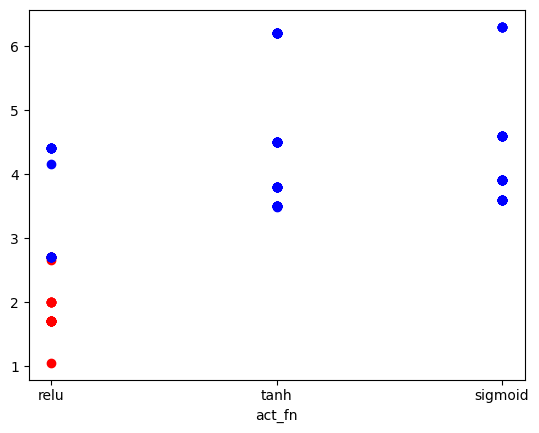

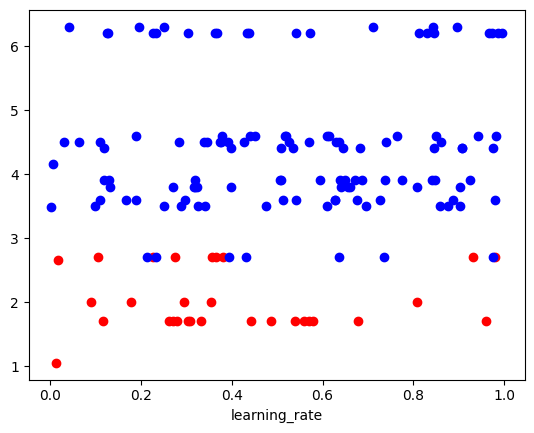

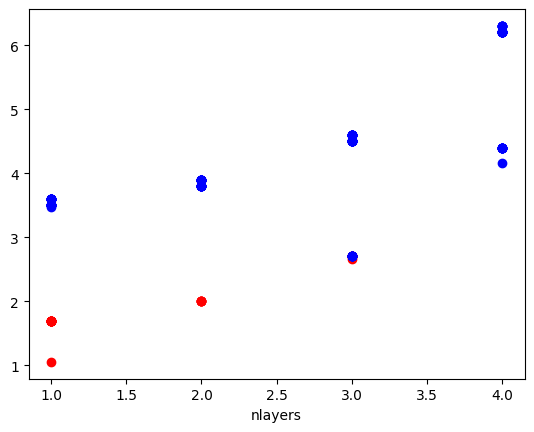

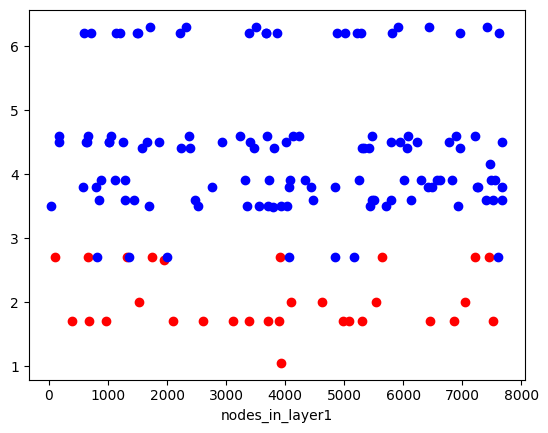

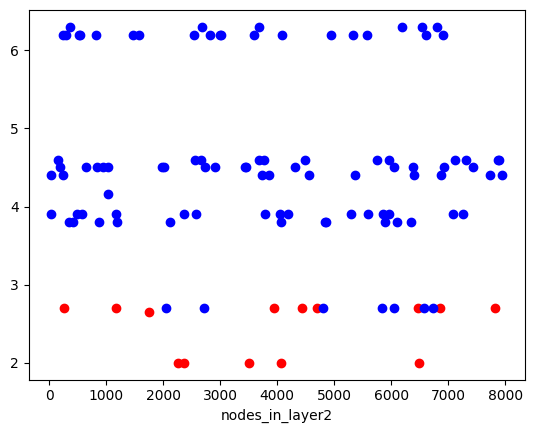

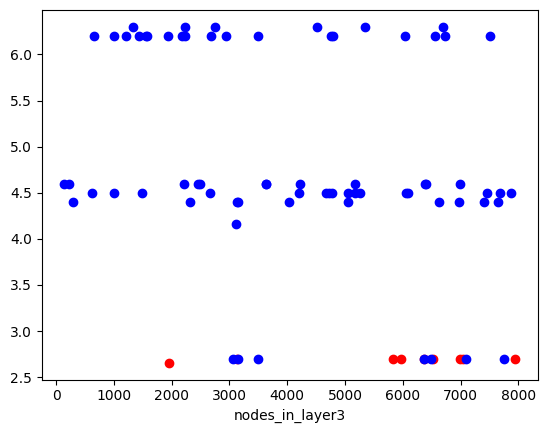

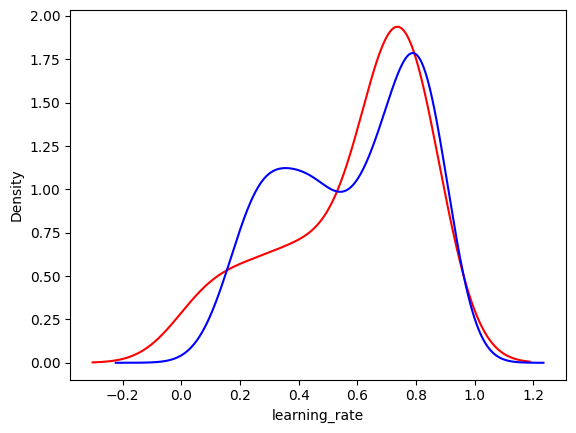

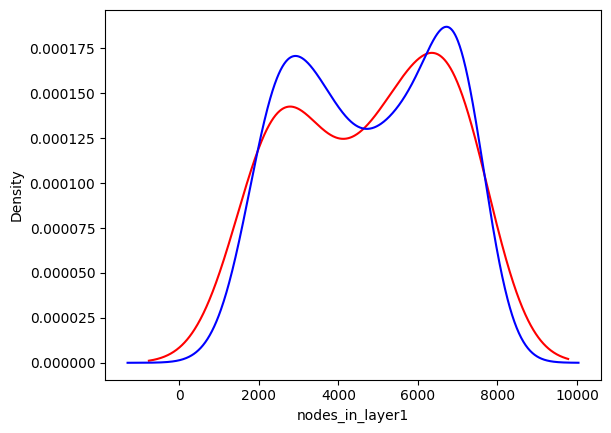

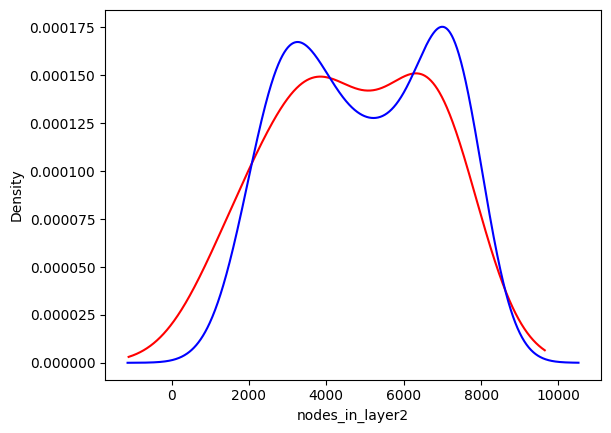

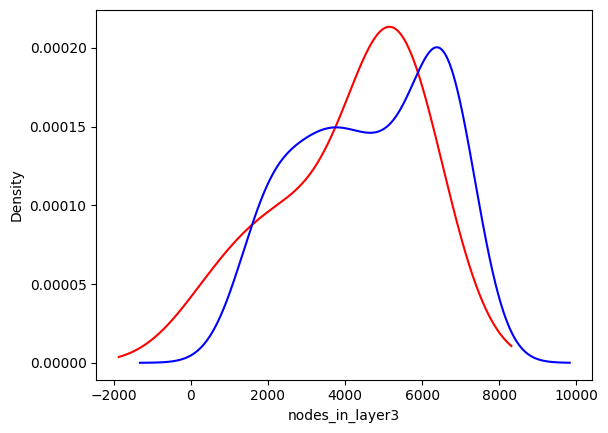

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\1136095992.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)


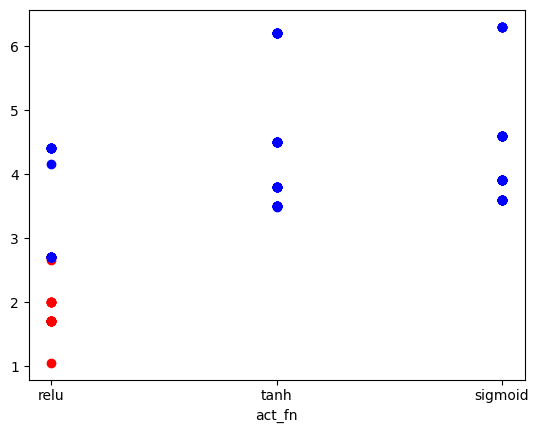

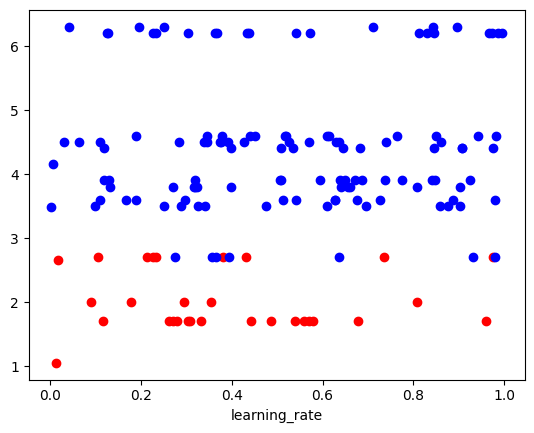

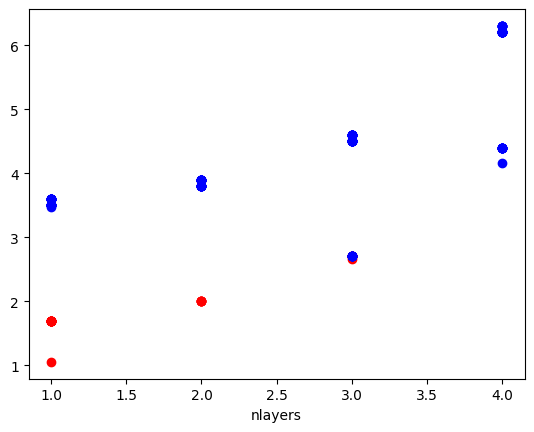

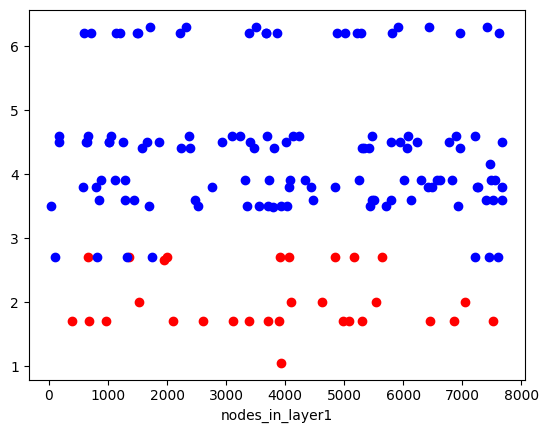

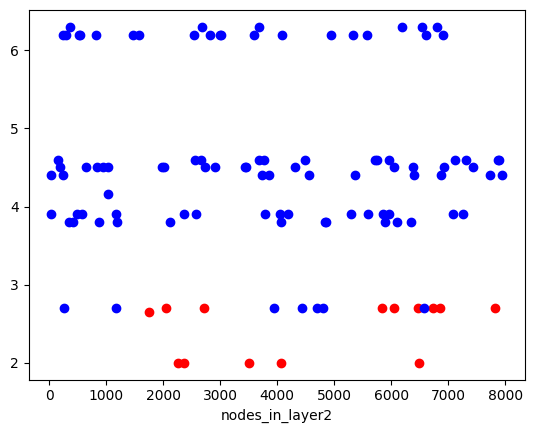

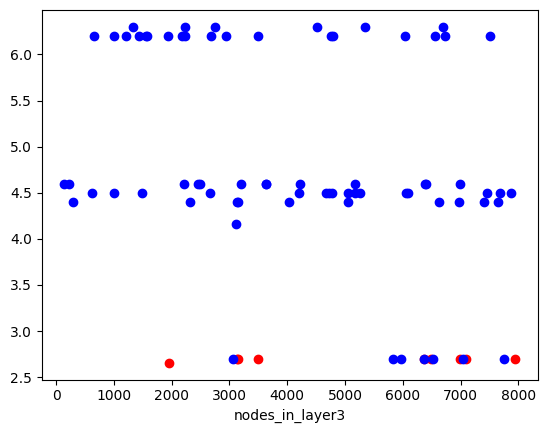

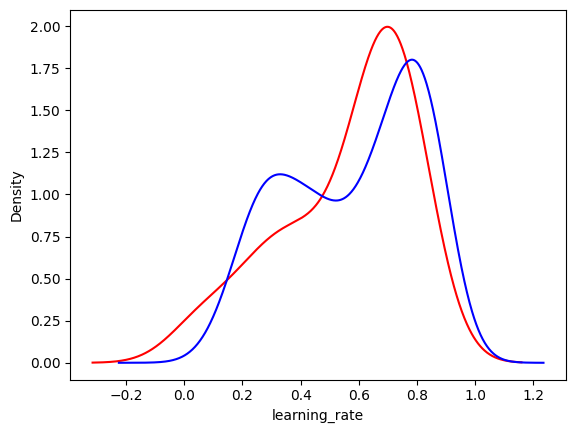

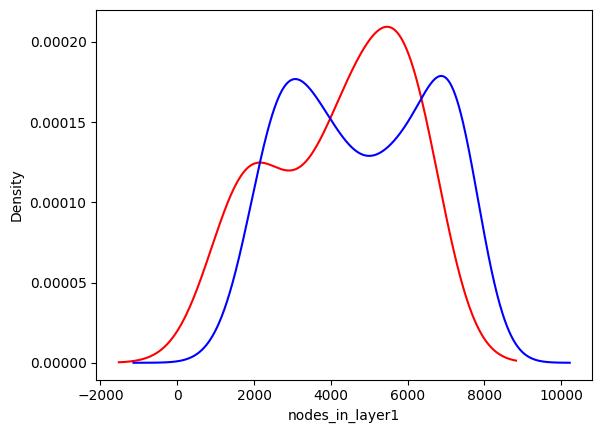

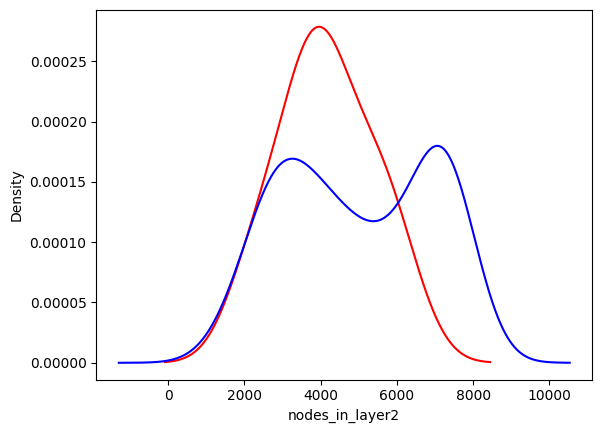

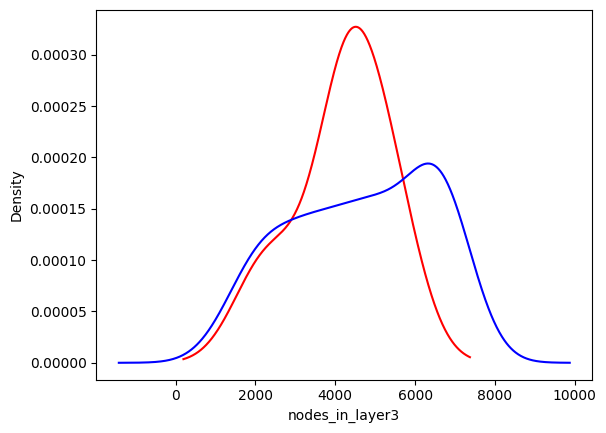

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\1136095992.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)


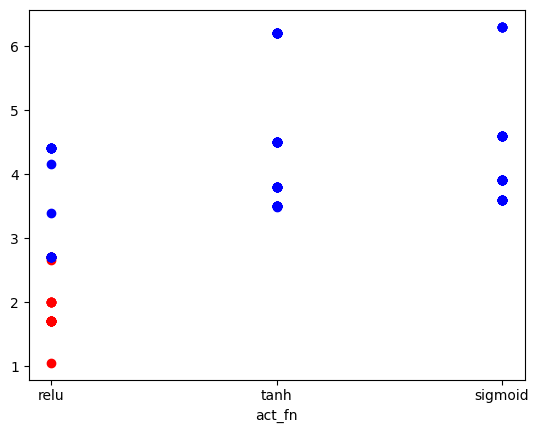

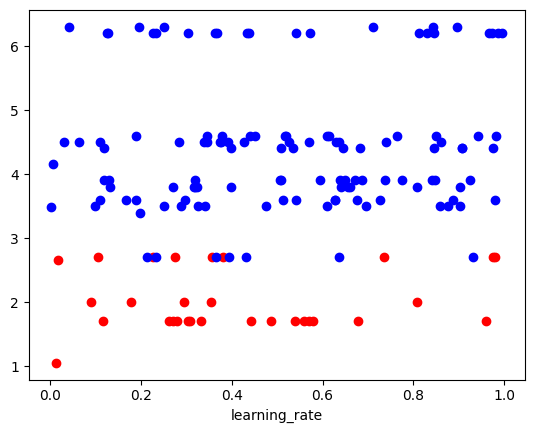

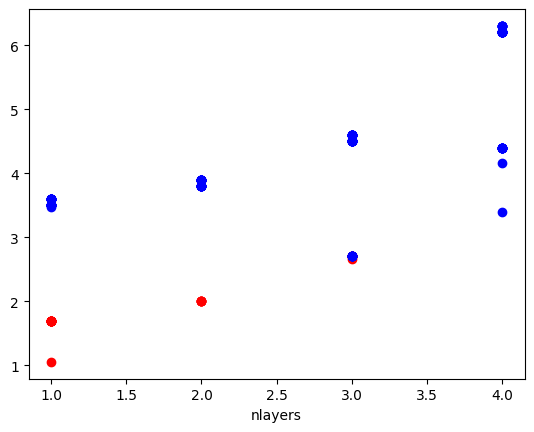

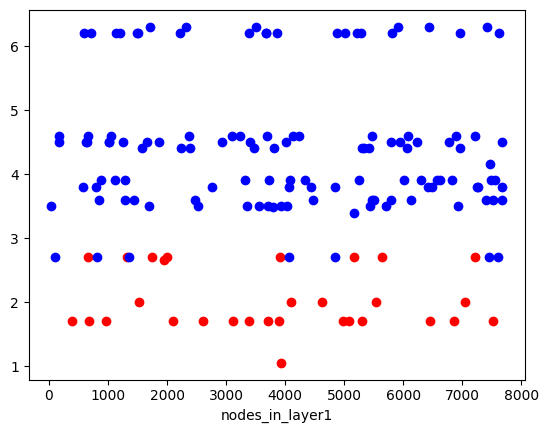

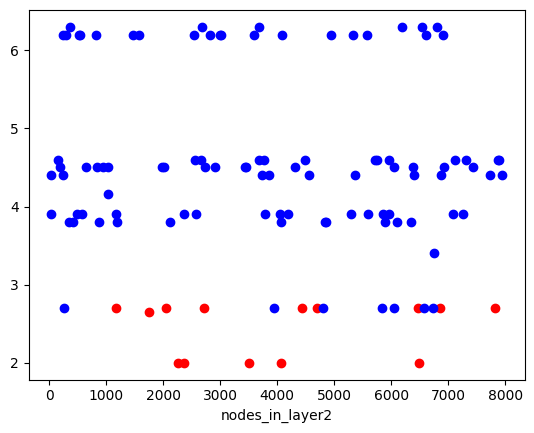

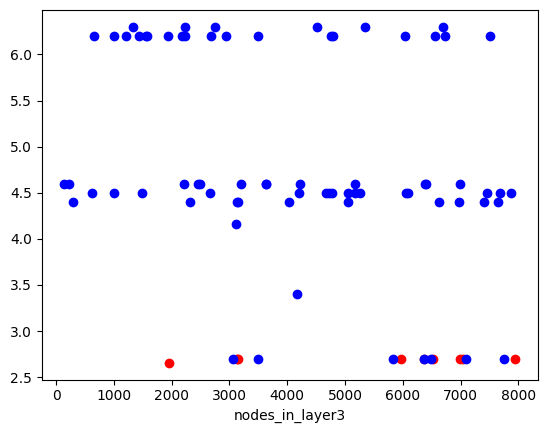

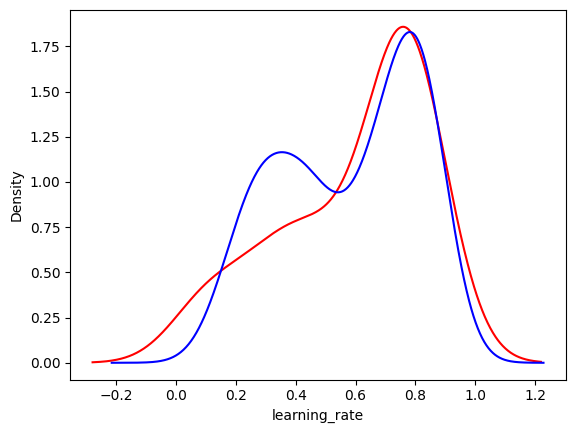

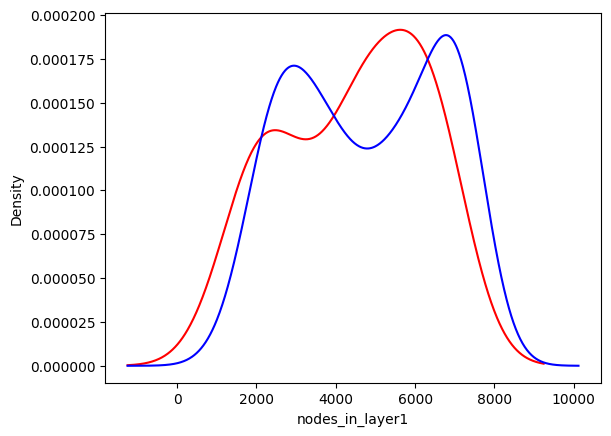

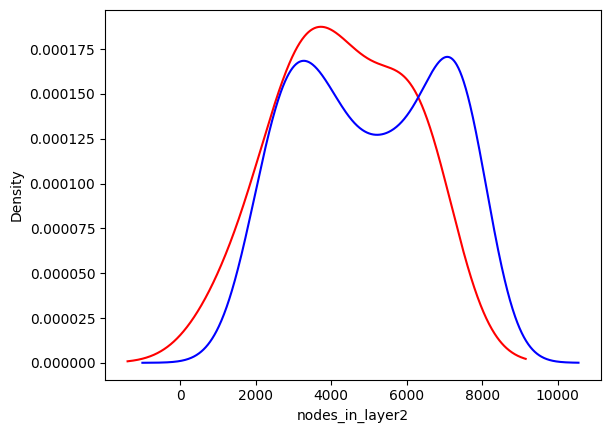

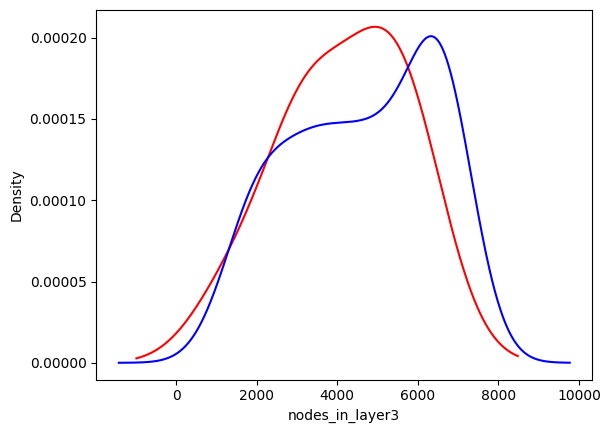

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\1136095992.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)


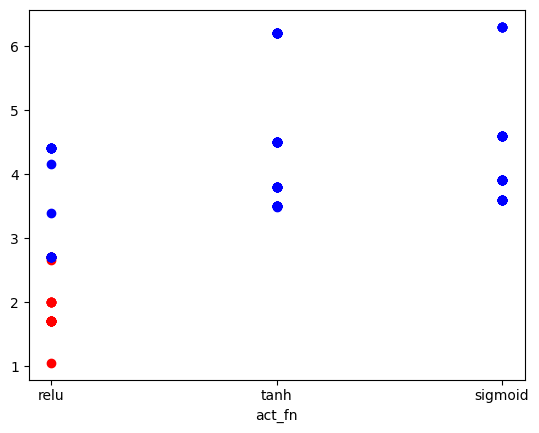

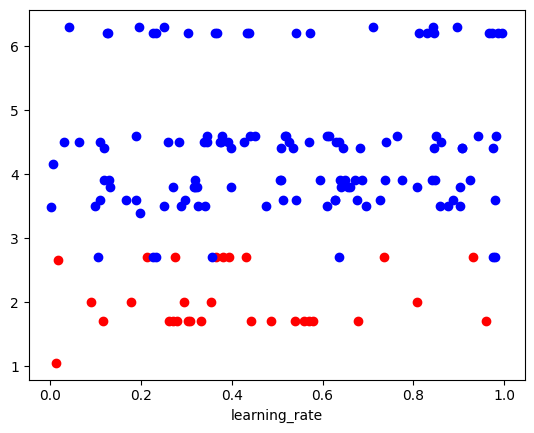

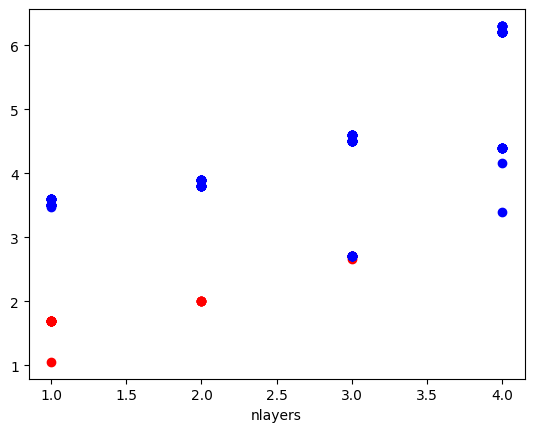

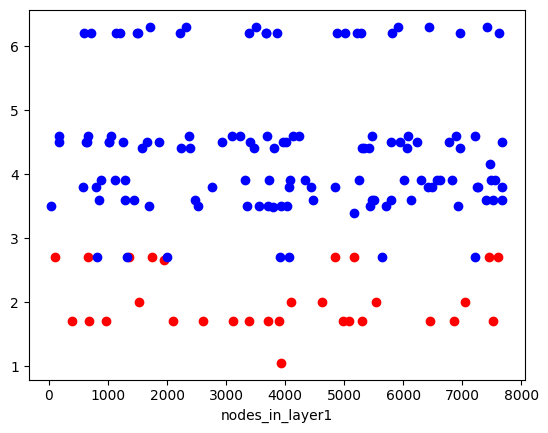

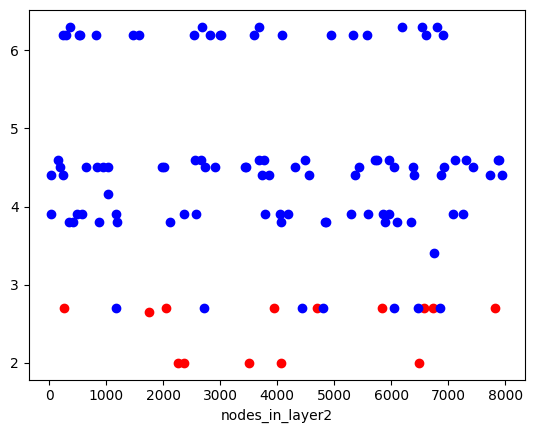

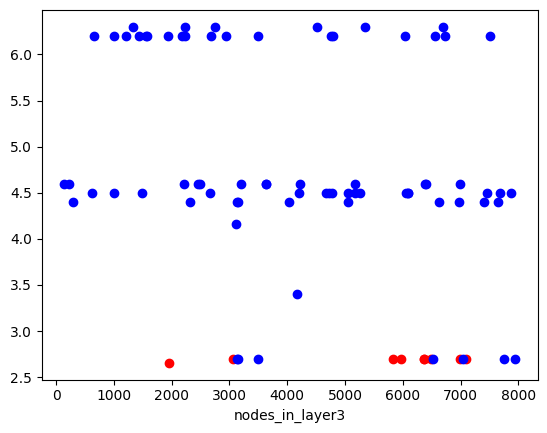

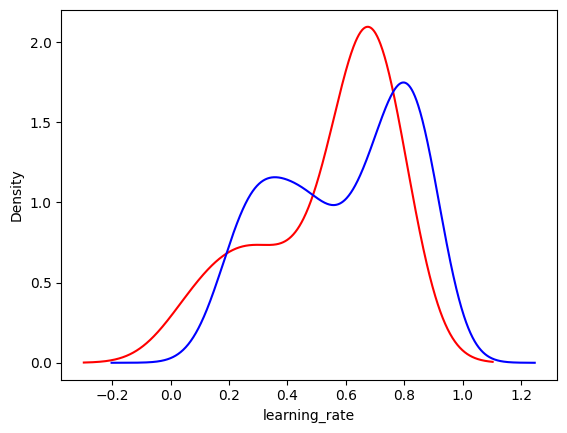

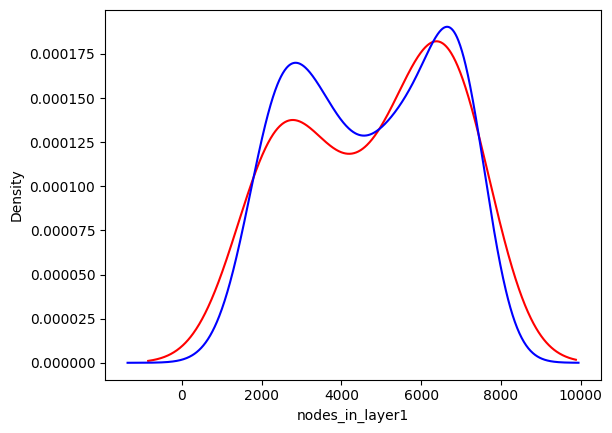

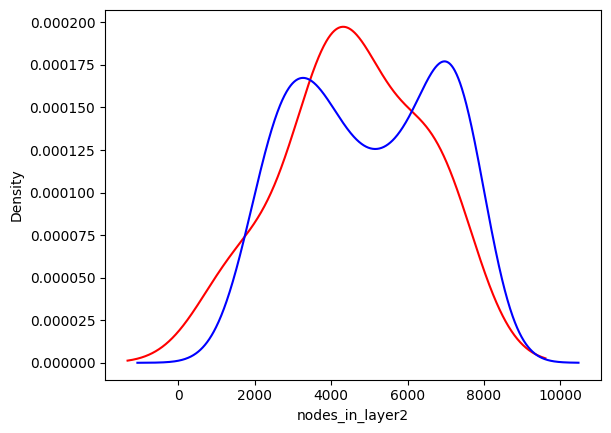

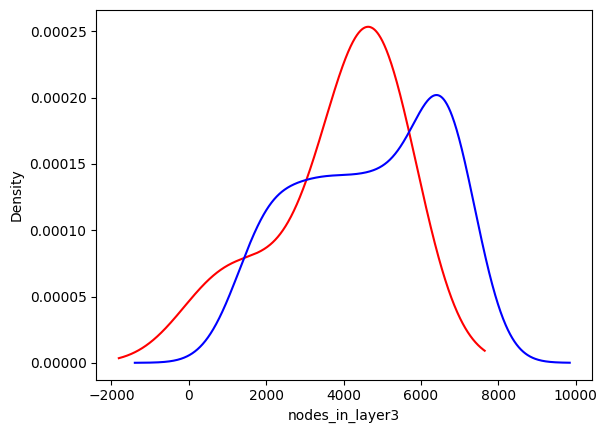

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\1136095992.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)


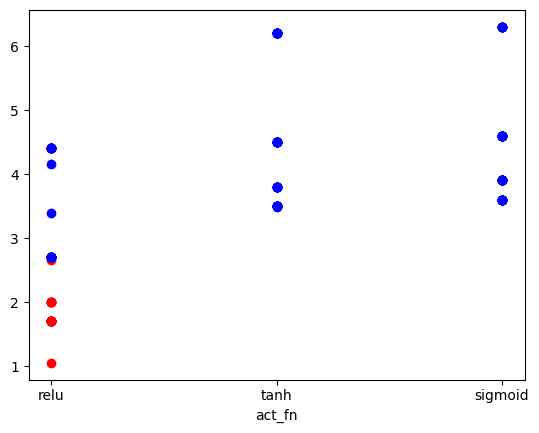

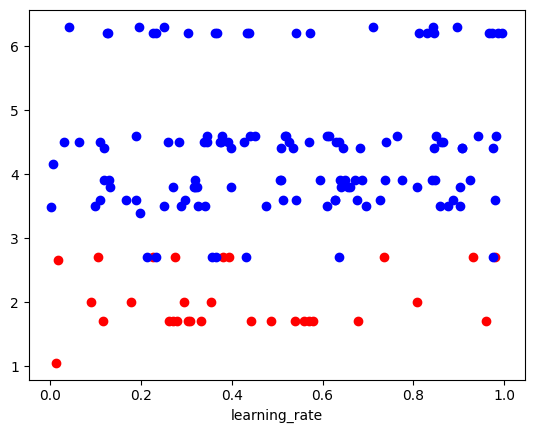

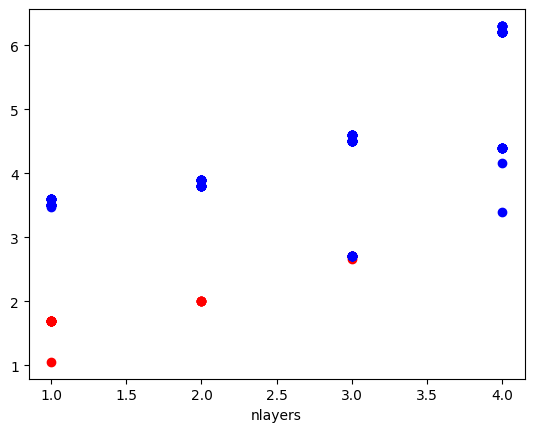

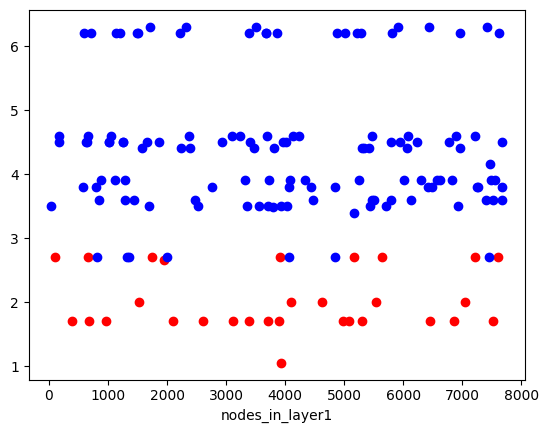

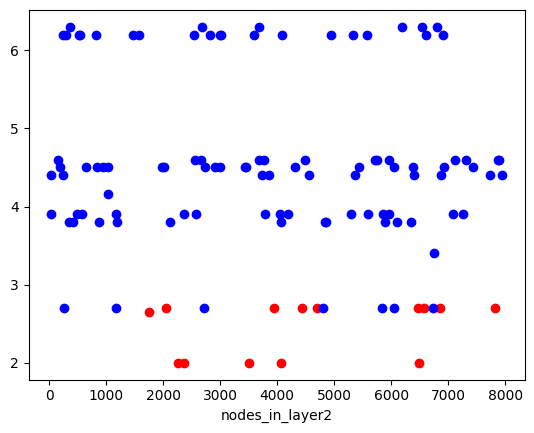

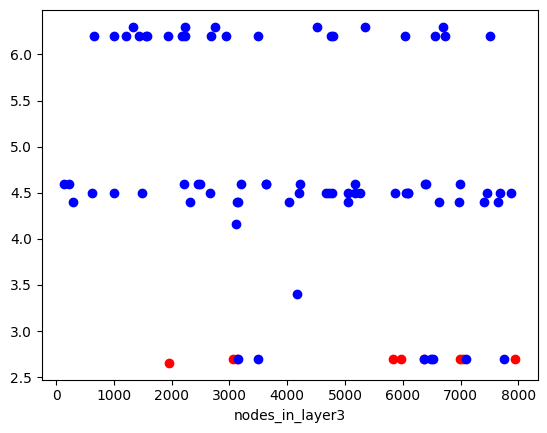

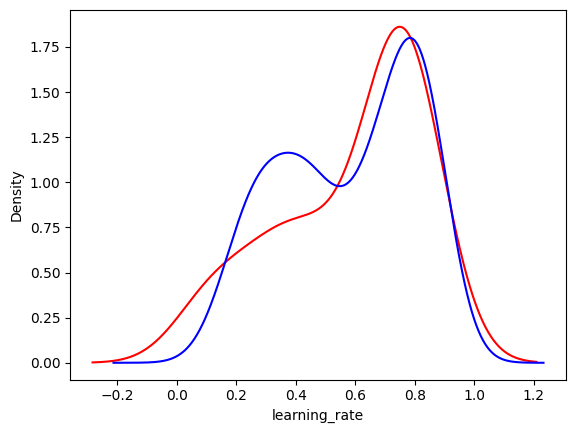

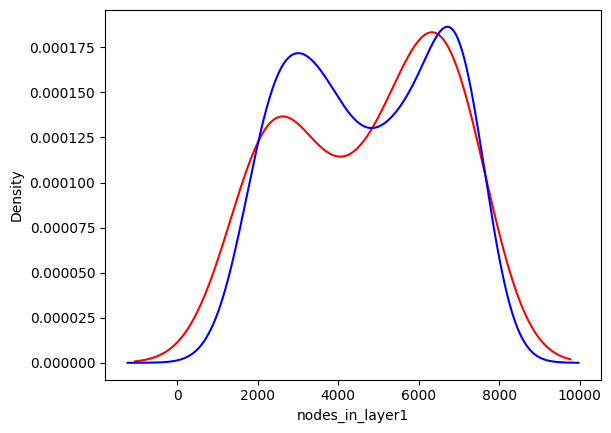

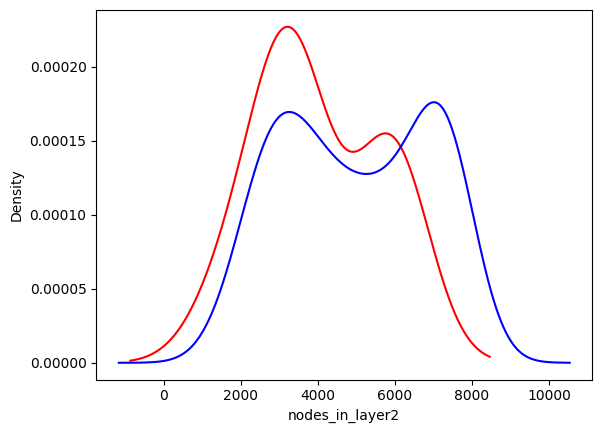

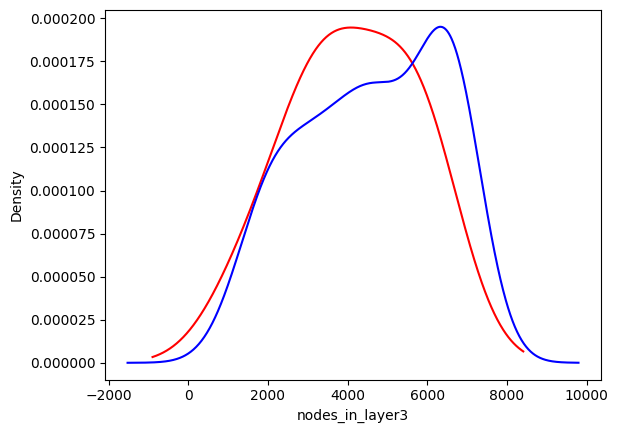

C:\Users\mally\AppData\Local\Temp\ipykernel_6892\1136095992.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyper_parameters = hyper_parameters.append({'configs': samples,"loss":GET_CONFIG_PERFORMANCE(samples)}, ignore_index=True)


In [106]:
tpe('bad_range')